# Insect Identification & Classification Project

This is an image classification problem of 291 species of Insects using  63,364 images from the Natural History Museum London

Source: https://zenodo.org/record/3549369#.XvI_jMfVLIU

#  Import Libraries

In [41]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import random
import time

from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T

from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid


# Read the data

In [42]:
# Load the paths to the images in a directory

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        file_name=[]
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            
            if img is not None:
                end=filename.find(".")
                file_name.append(file[0:end])
                images.append(img)
                
        return images, file_name
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

# Set up the data and a label dictionary

In [43]:
# Load the paths on the images
images = []
path = "../input/insect-identification-from-habitus-images/database/"
for f in os.listdir(path):
    if "jpg" in os.listdir(path+f)[0]:
        images += load_images_from_folder(path+f,True,label = f)
      
    else: 
        for d in os.listdir(path+f):
            images += load_images_from_folder(path+f+"/"+d,True,label = f)
            
                        
# Create a dataframe with the paths and the label for each insect
df1 = pd.DataFrame(images, columns = ["insect_gbif", "path_img"])

file_name=[]
for i in range(len(df1["path_img"])):
    temp=df1.path_img[i].split('/')[-1].split('.')[0]
    file_name.append(temp)
file_name

df1['file_name'] = file_name
display(df1.describe())

display(df1)


,insect_gbif,path_img,file_name
count,63364,63364,63364
unique,291,63364,63364
top,9364935,../input/insect-identification-from-habitus-im...,d040s0032
freq,888,1,1


,insect_gbif,path_img,file_name
0,4474861,../input/insect-identification-from-habitus-im...,d007s0131
1,4474861,../input/insect-identification-from-habitus-im...,d007s0086
2,4474861,../input/insect-identification-from-habitus-im...,d007s0019
3,4474861,../input/insect-identification-from-habitus-im...,d007s0028
4,4474861,../input/insect-identification-from-habitus-im...,d007s0116
...,...,...,...
63359,1035195,../input/insect-identification-from-habitus-im...,d161s0629
63360,1035195,../input/insect-identification-from-habitus-im...,d161s0249
63361,1035195,../input/insect-identification-from-habitus-im...,d161s0353
63362,1035195,../input/insect-identification-from-habitus-im...,d161s0616


In [44]:
labels = df1["insect_gbif"].unique()

labels_dict = dict(zip(range(len(labels)),labels))
labels_dict 

{0: '4474861',
 1: '1036203',
 2: '4472858',
 3: '1037633',
 4: '5872119',
 5: '8104778',
 6: '1035231',
 7: '5755978',
 8: '4478699',
 9: '4988484',
 10: '1035185',
 11: '8307815',
 12: '5755969',
 13: '1035208',
 14: '5757310',
 15: '1036958',
 16: '5755302',
 17: '4475908',
 18: '5872109',
 19: '4475179',
 20: '5873211',
 21: '4308789',
 22: '6097890',
 23: '6097896',
 24: '6097854',
 25: '9027622',
 26: '4471235',
 27: '4308800',
 28: '5872954',
 29: '5755339',
 30: '4475157',
 31: '1035578',
 32: '4475128',
 33: '5755066',
 34: '5753725',
 35: '5873271',
 36: '5716411',
 37: '7387665',
 38: '7975487',
 39: '5755950',
 40: '8139233',
 41: '1036255',
 42: '4478695',
 43: '8600499',
 44: '4479895',
 45: '8236590',
 46: '6097885',
 47: '7873810',
 48: '4475127',
 49: '4476667',
 50: '5756814',
 51: '5755011',
 52: '5873525',
 53: '1035290',
 54: '4308815',
 55: '6097912',
 56: '4472913',
 57: '5755027',
 58: '1036216',
 59: '4475213',
 60: '9252314',
 61: '8378220',
 62: '4480502',
 6

# Exlporatory Data Analysis (EDA)

Let us look at the data and make some initial conclusions

In [45]:
num_images = len(df1["insect_gbif"])
print('Number of images are:', num_images)
no_labels=len(labels)
print('Number of insect species are:', no_labels)

Number of images are: 63364
Number of insect species are: 291


Are images equally distributed between different insect species?

Let's plot a graph and see!

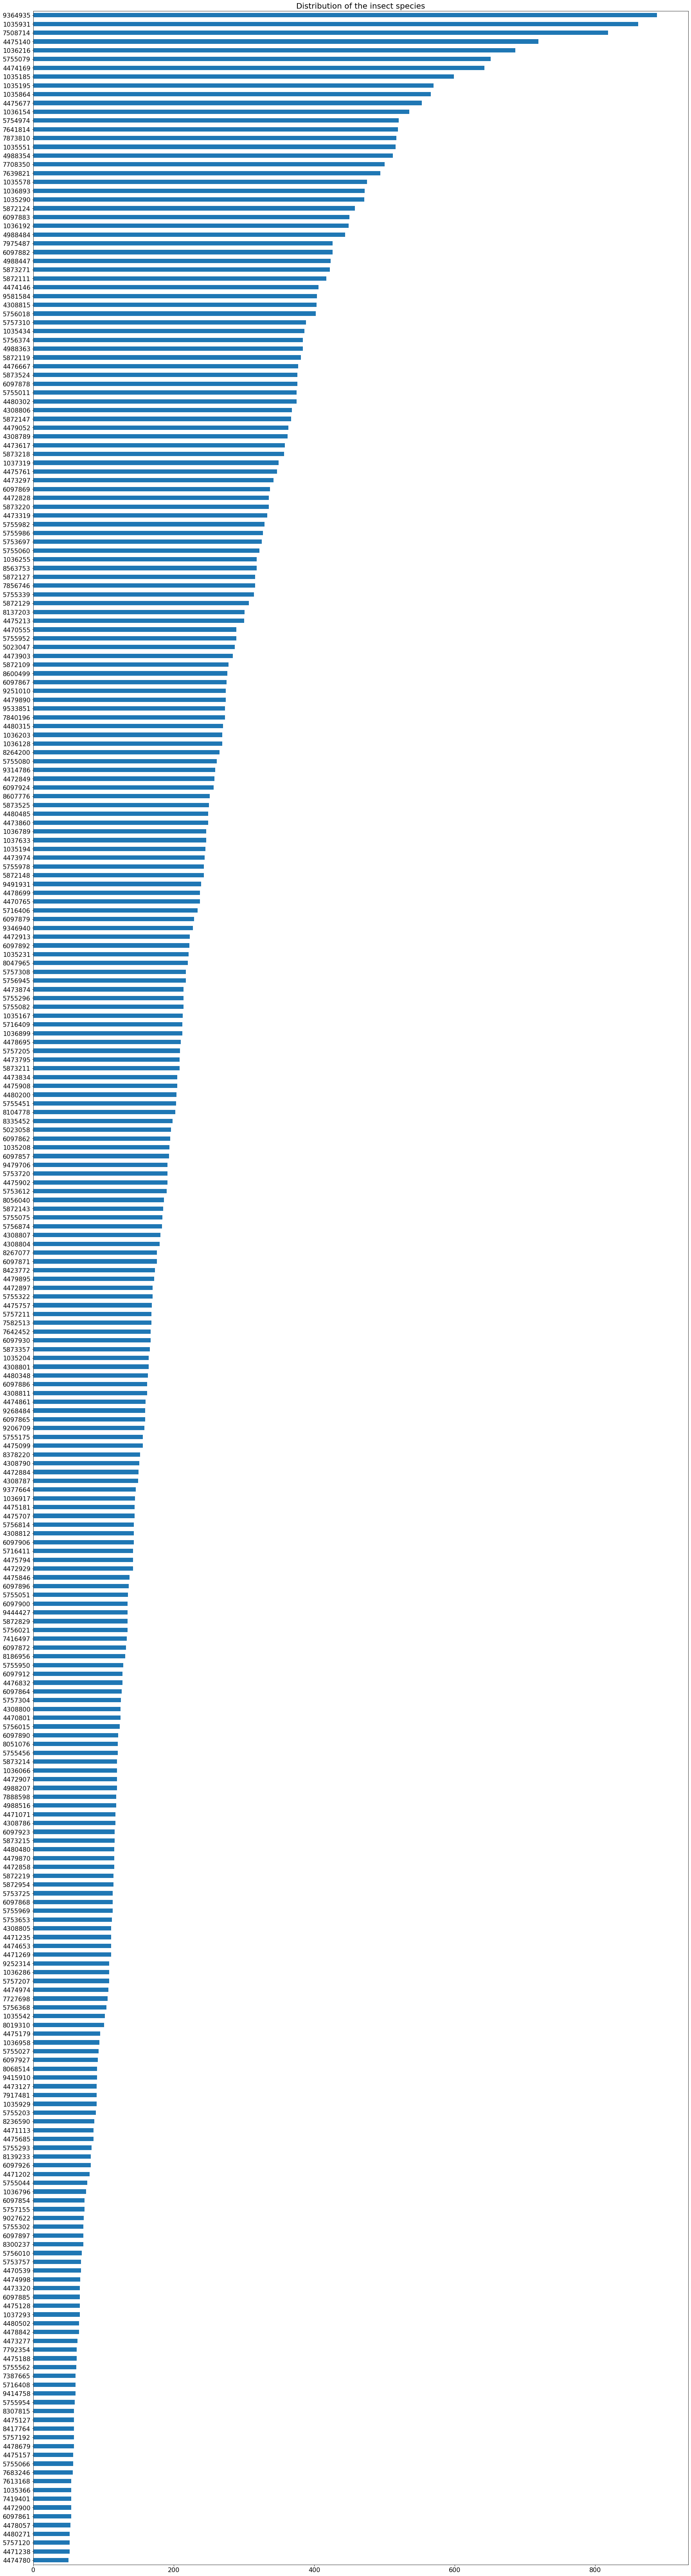

In [46]:
bar = df1["insect_gbif"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Distribution of the insect species", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

lets also make a table.. may be better as there are 200+ species

In [47]:
df1["insect_gbif"].value_counts()

9364935    888
1035931    861
7508714    818
4475140    719
1036216    686
          ... 
4478057     53
4480271     52
5757120     52
4471238     52
4474780     50
Name: insect_gbif, Length: 291, dtype: int64

It is a very unbalanced data. Some insect species have only 50 images, while others have 888!

# Split data into test, train and validation

In [48]:
train, validate, test = np.split(df1.sample(frac=1), [int(.6*len(df1)), int(.8*len(df1))])

display(train.describe())
display(validate.describe())
display(test.describe())

,insect_gbif,path_img,file_name
count,38018,38018,38018
unique,291,38018,38018
top,9364935,../input/insect-identification-from-habitus-im...,d213s0344
freq,528,1,1


,insect_gbif,path_img,file_name
count,12673,12673,12673
unique,291,12673,12673
top,1035931,../input/insect-identification-from-habitus-im...,d120s0293
freq,182,1,1


,insect_gbif,path_img,file_name
count,12673,12673,12673
unique,291,12673,12673
top,9364935,../input/insect-identification-from-habitus-im...,d198s0025
freq,189,1,1


Some may prefer only test abd validation

you may combine two data sets- this will result in only train and validation set

comment or delete the below code if you want three sets of data

In [49]:
df=train.append(test, ignore_index=True)
df.describe()

,insect_gbif,path_img,file_name
count,50691,50691,50691
unique,291,50691,50691
top,9364935,../input/insect-identification-from-habitus-im...,d040s0032
freq,717,1,1


# Image Analysis

Let us display 20 picture of the dataset with their labels

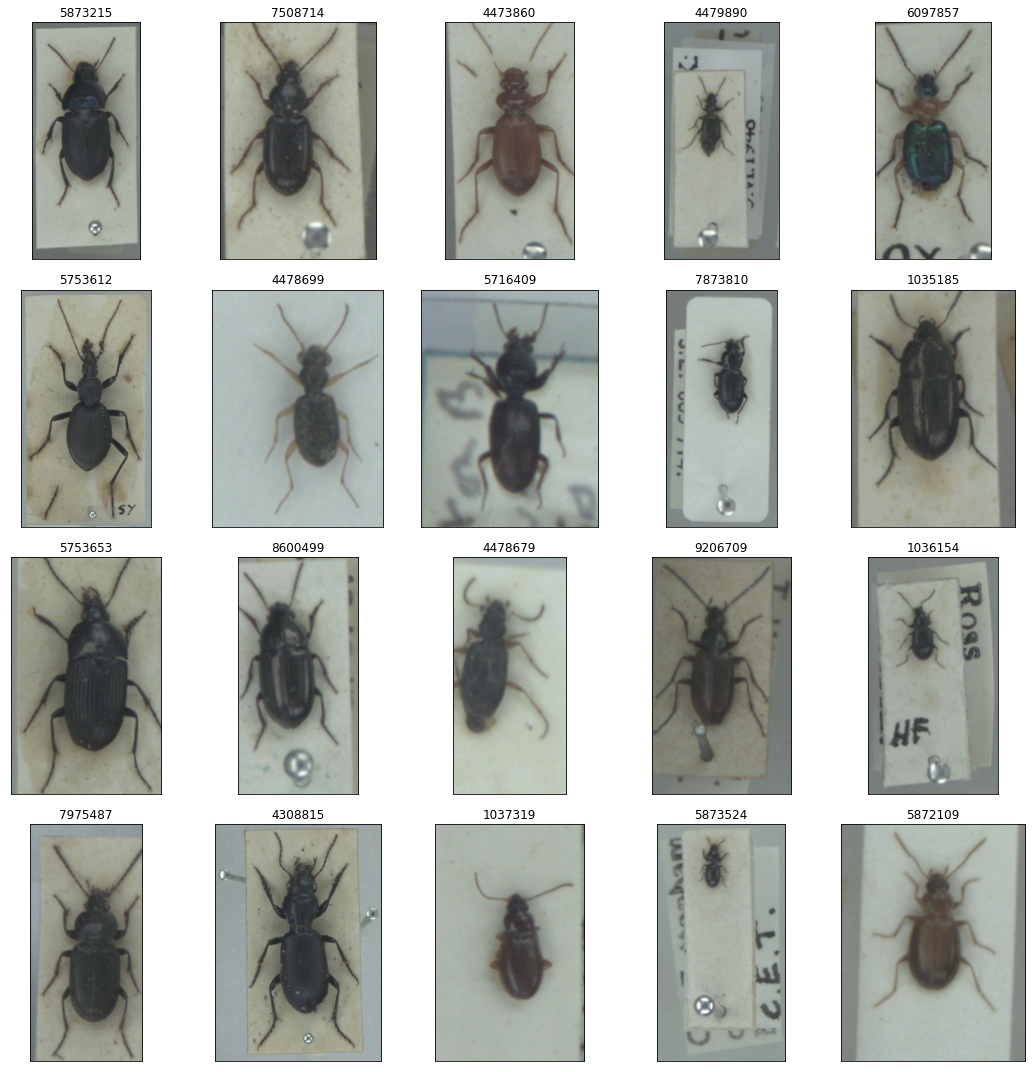

In [50]:
# Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path_img[i]))
    ax.set_title(df.insect_gbif[i])
plt.tight_layout()
plt.show()

What do you observe?

All images are of differnt sizes

The backgrounsd vary a bit and as these are from a museum, there are the nals and other marks

# Image transforms using PyTorch

In [51]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
#this will resize the image 
    T.Resize((256,256)),   
   
#Randomly change the brightness, contrast and saturation of an image
#    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),    

#this will remove parts (crop) the Image at a random location.   
#    T.RandomCrop(32, padding=4, padding_mode='reflect'),   

#Horizontally flip (rotate by 180 degree) the given image randomly; default is 50% of images
    T.RandomHorizontalFlip(), 
    
#Rotate the image by angle -here by 10%
    T.RandomRotation(10),
    
#convert it to a tensor   
    T.ToTensor(),

#Normalize a tensor image with mean and standard deviation - here with the Imagenet stats
    T.Normalize(*imagenet_stats,inplace=True)
    
#Randomly selects a rectangle region in an image and erases its pixels.    
#    T.RandomErasing(inplace=True)
])

val_tfms = T.Compose([
#this will resize the image 
    T.Resize((256,256)),   
     
#convert it to a tensor   
    T.ToTensor(),

#Normalize a tensor image with mean and standard deviation - here with the Imagenet stats
    T.Normalize(*imagenet_stats,inplace=True)
    
])

In [52]:
class InsectDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['path_img'], row['insect_gbif']
        img = Image.open(img_id)
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [53]:
train_ds = InsectDataset(train,transform=train_tfms)
val_ds = InsectDataset(validate, transform=val_tfms)

In [56]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)

# View Sample Images after Transform

Labels: 1036203


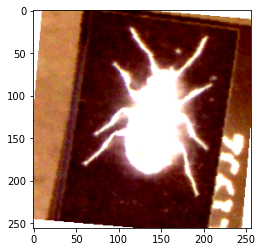

In [57]:
show_sample(*train_ds[241])

Labels: 5872119


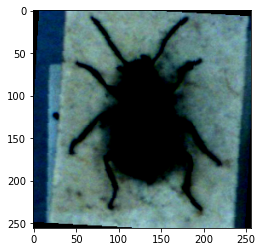

In [58]:
show_sample(*train_ds[1149], invert= False)

# Lets GO!!

Lets make an image classification model! Hope this is a good starter for you!

Thanks and all the best!